# Environment Setup

In [32]:
!pip install h5py
!pip install tensorflow -U
!pip install sklearn
!pip install seaborn

!rm -fr cv-workshop
!git clone https://github.com/summukhe/cv-workshop.git
    
cv_project = 'cv-workshop/notebooks'

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Requirement already up-to-date: tensorflow in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-pac

# Simple CNN Models
## loading the library

In [9]:
import os
import json
import h5py
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from skimage import data
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from keras.utils.vis_utils import plot_model

# Conv2D and Image Filter

A 2D convolution is equivalent to image filter. 

<div><img src="https://i.stack.imgur.com/VRUIm.jpg" width="500"></div>

We demonstrate the equivalence of the conv2D and image filter output.

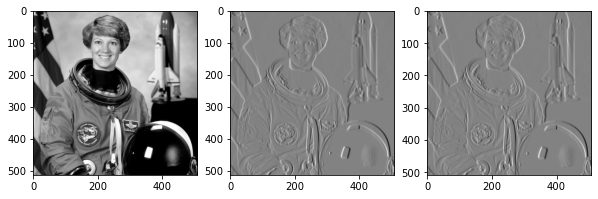

In [10]:
vertical_border = np.array([[1, 1, 0, -1, -1], 
                            [1, 1, 0, -1, -1], 
                            [1, 1, 0, -1, -1],
                            [1, 1, 0, -1, -1],
                            [1, 1, 0, -1, -1]])

img_astronaut = data.astronaut()
img_astronaut_gray = rgb2gray(img_astronaut)

# Using Edge Filter on astronaut
img_astronaut_filtered = sc.ndimage.convolve(img_astronaut_gray, vertical_border)


# Generating Neural Layer with Conv2D
conv_layer_inst = keras.layers.Conv2D(1, kernel_size=(5, 5), use_bias=False)

# Defining input shape
input_layer = tf.TensorShape([None, img_astronaut.shape[0], img_astronaut.shape[1], 1])

# Building the model
conv_layer_inst.build(input_layer)

# Setting Instance weight
conv_layer_inst.set_weights([vertical_border[:, ::-1].reshape((5, 5, 1, 1)).astype(np.float32)])

# Processing astronaut image
img_astronaut_conv = conv_layer_inst(img_astronaut_gray.reshape(1, 512, 512, 1)).numpy()[0][...,0]


fig, axs = plt.subplots(1, 3, figsize=(10, 20))
axs[0].imshow(img_astronaut_gray, cmap=plt.cm.gray)
axs[1].imshow(img_astronaut_filtered, cmap=plt.cm.gray)
axs[2].imshow(img_astronaut_conv, cmap=plt.cm.gray)
plt.show()


# Max Pooling

<div><img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width="400"></div>

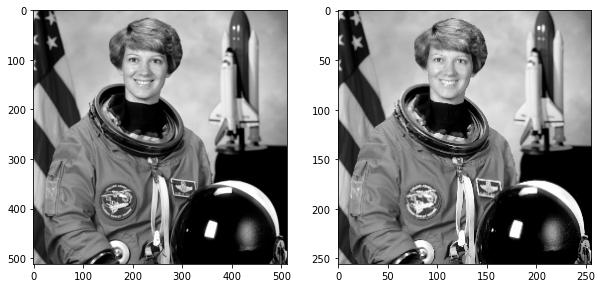

In [11]:
maxpool_inst = keras.layers.MaxPooling2D((2, 2))
input_layer = tf.TensorShape((None, ) + img_astronaut_gray.shape + (1, ))
maxpool_inst.build(input_layer)

img_astronaut_maxpool = maxpool_inst(img_astronaut_gray.reshape((1, 512, 512, 1))).numpy()[0][...,0]

fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs[0].imshow(img_astronaut_gray, cmap=plt.cm.gray)
axs[1].imshow(img_astronaut_maxpool, cmap=plt.cm.gray)
plt.show()


# Data Loading

In [12]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

display("x_train shape: {} x {} x {} x {}".format(*x_train.shape))
display("Number of train samples: {} ".format(x_train.shape[0]))
display("Numer of test samples: {}".format(x_test.shape[0]))


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


'x_train shape: 60000 x 28 x 28 x 1'

'Number of train samples: 60000 '

'Numer of test samples: 10000'

# Example Training Data

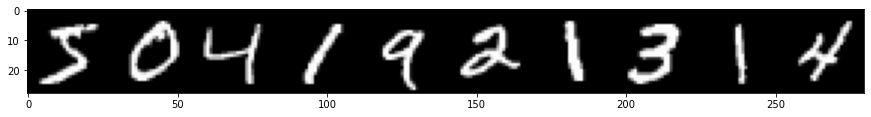

In [13]:
n_example = 10
plt.figure(figsize=(15,15*n_example))
plt.imshow(np.squeeze(np.concatenate([x_train[i] for i in range(n_example)], axis=1)), cmap=plt.cm.gray)
plt.show()

# Training Model

Trained with a sequential model, containing sequence of `CONV2D` layer, following by a `Dense` layer. 

<div><img src="https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg" width="600"></div>

Loss function measures the model performance in terms of a scalar value. Categorical cross entropy is a common loss function used in multi-class classification problem

$$\mathcal{L} = -\sum^{N}_{i=0}\sum^{M}_{j=0} y_{ij} * log(\hat{y}_{ij})$$



In [14]:
model_path = os.path.join(cv_project, 'mnist_model.h5')

def get_digit_recognition_model():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape, name='inp_mnist_recognition'),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu", name='conv2d_1_recognition'),
            layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1_recognition'),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu", name='conv2d_2_recognition'),
            layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2_recognition'),
            layers.Flatten(name='embedding_recognition'),
            layers.Dropout(0.5, name='dropout_recognition'),
            layers.Dense(num_classes, activation="softmax", name='classify_recognition'),
        ]
    )
    return model


if os.path.exists(model_path):
    model = keras.models.load_model(model_path)
else:
    model = get_digit_recognition_model()
    
    batch_size = 128
    epochs = 15
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    model.save(model_path)

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.027057470753788948
Test accuracy: 0.991599977016449


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_recognition (Conv2D (None, 24, 24, 16)        416       
_________________________________________________________________
maxpool_1_recognition (MaxPo (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2_recognition (Conv2D (None, 8, 8, 16)          6416      
_________________________________________________________________
maxpool_2_recognition (MaxPo (None, 4, 4, 16)          0         
_________________________________________________________________
embedding_recognition (Flatt (None, 256)               0         
_________________________________________________________________
dropout_recognition (Dropout (None, 256)               0         
_________________________________________________________________
classify_recognition (Dense) (None, 10)                2

# Model Prediction

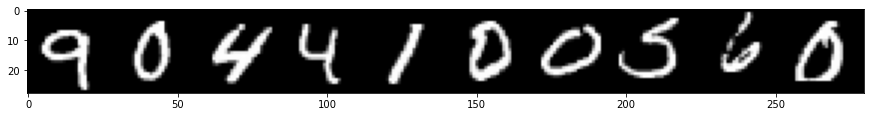

'Predictions: 9 0 4 4 1 0 0 5 6 0 '

In [18]:
idxs = [np.random.randint(x_test.shape[0]) for i in range(n_example)]
prediction = np.argmax(model.predict(x_test[idxs]), axis=1)

plt.figure(figsize=(15,15*n_example))
plt.imshow(np.squeeze(np.concatenate([x_test[i] for i in idxs], axis=1)), cmap=plt.cm.gray)
plt.show()

display("Predictions: {} ".format(' '.join(['%d' % s for s in prediction])))

# Gradient Computation

In [19]:
x = tf.constant(3.0)

with tf.GradientTape() as g:
    g.watch(x)
    y = x**3 

dy_dx = g.gradient(y, x).numpy()
display("dy/dx = {}".format(dy_dx))

'dy/dx = 27.0'

# GradCAM

<div><img src="https://www.researchgate.net/profile/Johannes-Kvam/publication/343127022/figure/fig1/AS:916034668224512@1595411092305/Overview-of-our-Principal-Feature-Visualisation-PFVmethod.png" width="400"></div>

In [22]:
def gradcam_heatmap(img_array, 
                    model, 
                    last_conv_layer_name, 
                    pred_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



def show_gradient(img, heatmap, alpha=0.1):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("viridis")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha  + (img * 255)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    fig, axs = plt.subplots(1, 2, figsize=(10,20))
    axs[0].imshow(np.squeeze(img), cmap=plt.cm.gray)
    axs[1].imshow(superimposed_img)
    plt.show()

# GradCAM example on MNIST

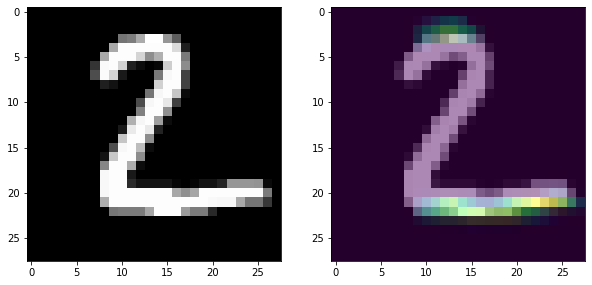

In [23]:
img_array = x_test[[1]]
img_pred = model.predict(img_array)[0]
focus = gradcam_heatmap(img_array, model, 'conv2d_1_recognition', np.argmax(img_pred))
show_gradient(img_array[0], focus, alpha=1.0)

# Embedding / Representation Space

In [24]:
emb_model = tf.keras.models.Model(model.inputs, [model.layers[4].output])


random_index = np.random.choice(x_test.shape[0], 600)
emb_vector = emb_model.predict(x_test[random_index])
tags = np.argmax(y_test[random_index], axis=1)

emb_proj = TSNE(n_components=2).fit_transform(emb_vector)

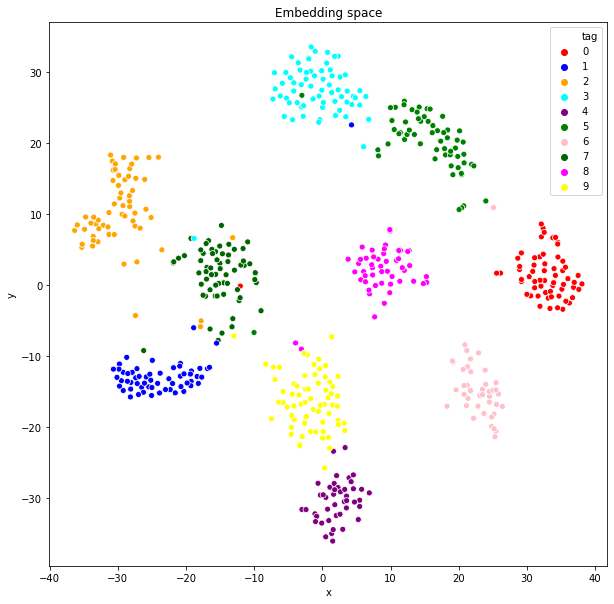

In [26]:
emb_df = pd.DataFrame(emb_proj, columns=['x', 'y'])
emb_df['tag'] = tags

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.scatterplot(data=emb_df, 
                x='x', 
                y='y', 
                hue='tag', 
                ax=ax, 
                palette={0: 'red', 
                         1: 'blue', 
                         2: 'orange',
                         3: 'cyan',
                         4: 'purple',
                         5: 'green',
                         6: 'pink',
                         7: 'darkgreen',
                         8: 'magenta',
                         9: 'yellow',
                        })
plt.title('Embedding space')
plt.show()

# Embedding Is Guided by Task

## Same Data Different Task

Instead of digit recognition we convert the model into odd even recognition problem. Odd {1, 3, 5, 7, 9}, Even {0, 2, 4, 6, 8}

In [27]:
y_test_odd_even = (np.argmax(y_test, axis=1) % 2 == 0).astype(int)
y_train_odd_even = (np.argmax(y_train, axis=1) % 2 == 0).astype(int)

model_path = os.path.join(cv_project, 'mnist_oddeven.h5')

def get_oddeven_model():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape, name='inp_mnist_oddeven'),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu", name='conv2d_1_oddeven'),
            layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1_oddeven'),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu", name='conv2d_2_oddeven'),
            layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2_oddeven'),
            layers.Flatten(name='embedding_oddeven'),
            layers.Dropout(0.5, name='dropout_oddeven'),
            layers.Dense(1, activation="sigmoid", name='classify_oddeven'),
        ]
    )
    return model


if os.path.exists(model_path):
    model_oddeven = keras.models.load_model(model_path)
else:
    model_oddeven = get_oddeven_model()
    batch_size = 128
    epochs = 15
    model_oddeven.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model_oddeven.fit(x_train, y_train_odd_even, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    model_oddeven.save(model_path)


# Checking Odd Even Model

Displaying the model accuracy of the odd even model task

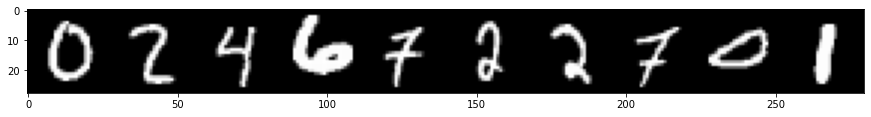

'Predictions: 1 1 1 1 0 1 1 0 1 0 '

In [29]:
idxs = [np.random.randint(x_test.shape[0]) for i in range(n_example)]
prediction = np.round(model_oddeven.predict(x_test[idxs]).reshape(-1))

plt.figure(figsize=(15,15*n_example))
plt.imshow(np.squeeze(np.concatenate([x_test[i] for i in idxs], axis=1)), cmap=plt.cm.gray)
plt.show()

display("Predictions: {} ".format(' '.join(['%d' % s for s in prediction])))

# Representation Space For Odd Even Task

In [30]:
emb_model_oddeven = tf.keras.models.Model(model_oddeven.inputs, [model_oddeven.layers[4].output])


random_index = np.random.choice(x_test.shape[0], 600)
emb_vector = emb_model_oddeven.predict(x_test[random_index])
tags = y_test[random_index]

emb_proj = TSNE(n_components=2).fit_transform(emb_vector)

# Plotting the embedding space

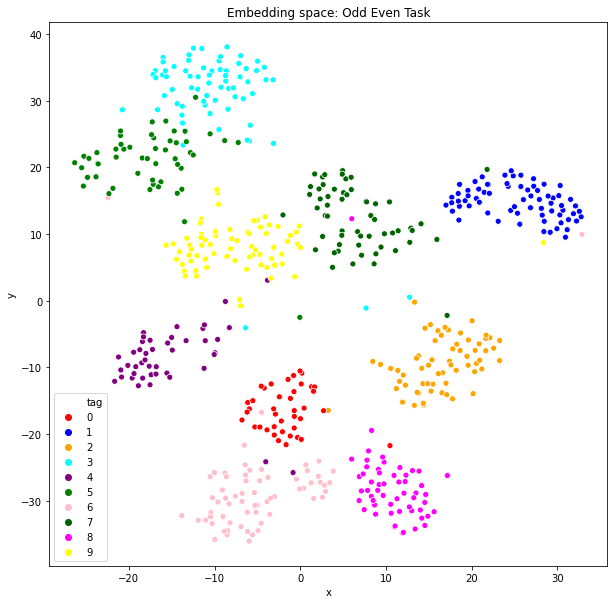

In [31]:
emb_df = pd.DataFrame(emb_proj, columns=['x', 'y'])
emb_df['tag'] = np.argmax(y_test[random_index], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.scatterplot(data=emb_df, 
                x='x', 
                y='y', 
                hue='tag', 
                ax=ax, 
                palette={0: 'red', 
                         1: 'blue', 
                         2: 'orange',
                         3: 'cyan',
                         4: 'purple',
                         5: 'green',
                         6: 'pink',
                         7: 'darkgreen',
                         8: 'magenta',
                         9: 'yellow',
                        })
plt.title('Embedding space: Odd Even Task')
plt.show()